In [2]:
from load_dataset import *
from model import *
from config import *
from fit_constants import *
from metrics import *

## Load the model with weights

In [3]:
#load model
model = ConditionalD3PMTransformer(
    vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, num_layers=NUM_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD, seq_len=SEQ_LEN,
    condition_feature_dim=CONDITION_FEATURE_DIM,
    num_timesteps=NUM_TIMESTEPS, dropout=DROPOUT
).to(DEVICE)
model.load_state_dict(torch.load("pretrained_weights/best_d3pm_pointnet_crossattn_multidim.pth", map_location=DEVICE))
model.eval()

diffusion = DiscreteDiffusion(num_timesteps=NUM_TIMESTEPS, vocab_size=VOCAB_SIZE, device=DEVICE)

## Load Dataset for Evaluation

In [4]:
data = load_diffusion_data(input_dir="data",file_name="valv9.json")

Loaded 18608 records from data/valv9.json


## Evaluate Dataset

In [9]:
batch_condition_size = 1024

batch_conditions = [item["X_Y_combined"] for item in data[:batch_condition_size]]  # List of arrays, length 10

condition_tensor = torch.from_numpy(np.array(batch_conditions)).float().to(DEVICE)

samples = diffusion.sample(model, condition_tensor, shape=(batch_condition_size, SEQ_LEN))

print("Sampled sequences shape:", samples.shape)  # Should be (10, SEQ_LEN)
print("Sampled sequences:", samples)

Sampling timestep 499/500   

Sampling timestep 1/500     
Sampling complete.
Sampled sequences shape: torch.Size([1024, 30])
Sampled sequences: tensor([[ 1,  4, 18,  ...,  0,  0,  0],
        [ 1,  4, 18,  ...,  0,  0,  0],
        [ 1,  4,  4,  ...,  0,  0,  0],
        ...,
        [ 1,  4,  4,  ...,  0,  0,  0],
        [ 1,  4,  4,  ...,  0,  0,  0],
        [ 1,  4,  4,  ...,  0,  0,  0]], device='cuda:0')


## Convert Tokenized Model Output to Sympy Symbolic Expressions

In [10]:
#Denormalize before fitting constants

from denormalize_dataset import *
denormed_data = denormalize(data)

Global X Mean: -5.1644239696904295e-05, X Std: 1.7320934427468708
Global Y Mean: 0.007551506222891395, Y Std: 4.109352444718347


Sampled sequence 0: tensor([ 1,  4, 18,  7,  4,  4, 18,  7, 12,  7,  5,  4,  5,  2,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C x2 * C +
Parsed RPN (indices): [np.int64(4), np.int64(18), np.int64(7), np.int64(4), np.int64(4), np.int64(18), np.int64(7), np.int64(12), np.int64(7), np.int64(5), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 4
Parsed RPN (tokens): C x2 * C C x2 * exp * + C +
Optimizing 4 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): False
  Message (DE): Maximum number of iterations has been exceeded.
  Final Loss: 0.000000
  Fitted Constants: [-0.73187935 -1.3588444   0.00691168  0.38284233]
  Number of function evaluations (NFEV): 6105
Sample 0 - R^2 Score: 1.0000, Acc_tau: 1.0000
Sampled sequence 1: tensor([ 1,  4, 18,  7,  4,  4, 18,  7,  4,  5, 11,  7,  5,  4,  5,  2,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Tru

/home/mvslab/Ryan_and_Ben/Symbolic_Diffusion/.venv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


Optimization finished.
  Success (DE): False
  Message (DE): Maximum number of iterations has been exceeded.
  Final Loss: 9.614393
  Fitted Constants: [-7.7556367  -5.346757   -0.450499    7.0164266  -0.17750417  5.10046
 -0.9023944 ]
  Number of function evaluations (NFEV): 10629
Sample 164 - R^2 Score: 0.8877, Acc_tau: 0.0000
Sampled sequence 165: tensor([ 1,  4,  4, 17,  7, 13,  7,  4,  5,  2,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C C x1 * log * C +
Parsed RPN (indices): [np.int64(4), np.int64(4), np.int64(17), np.int64(7), np.int64(13), np.int64(7), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 3
Parsed RPN (tokens): C C x1 * log * C +
Optimizing 3 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): True
  Message (DE): Optimization terminated successfully.
  Final Loss: 0.000000
  Fitted Constants: [-0.80202466  2.8188262  -0.63307434]
  Number of function

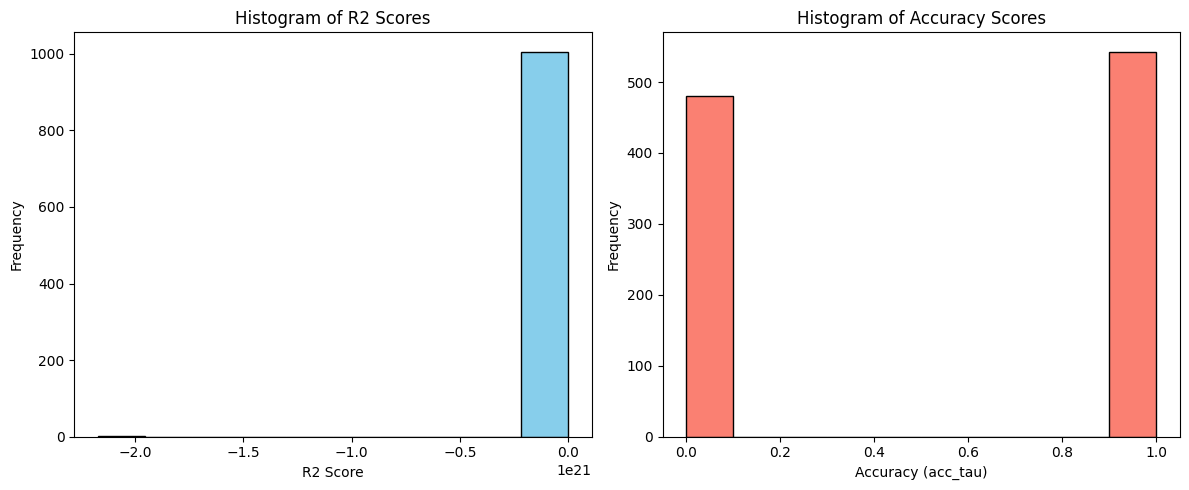

In [ ]:
vocab = {
    "<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3, "C": 4, "+": 5, "-": 6,
    "*": 7, "/": 8, "**": 9, "sin": 10, "cos": 11, "exp": 12, "log": 13,
    "2": 15, "3": 16, "x1": 17, "x2": 18
}

r2_scores = []
accuracy_scores_tau_0_1 = []
accuracy_scores_tau_0_01 = []
accuracy_scores_tau_0_001 = []

for i in range(batch_condition_size):
    print(f"Sampled sequence {i}:", samples[i])
    print("Ground Truth", data[i]["RPN"])
    predictor_function = create_rpn_fitting_function(samples[i], vocab, denormed_data[i]["X_Y_combined"])
    
    import matplotlib.pyplot as plt

    # Extract X and Y_true from the batch_condition and ground truth for this sample
    #X = np.array(batch_conditions[i])[:, :2]  # shape (N, 2)
    #Y_true = np.array([row[-1] for row in batch_conditions[i]])  # shape (N,)
    
    xy_array = np.array(denormed_data[i]["X_Y_combined"])  # shape (N, 3)
    X = xy_array[:, :2]  # shape (N, 2), just x1 and x2
    Y_true = xy_array[:, 2]  # shape (N,), just y

    # Predict Y values at the original points using the fit function
    Y_pred = predictor_function(X)
    Y_pred = np.array(Y_pred)
    
    r2 = r2_score_np(Y_true, Y_pred)
    acc_0_1 = acc_tau(Y_true, Y_pred, tau=0.1)
    acc_0_01 = acc_tau(Y_true, Y_pred, tau=0.01)
    acc_0_001 = acc_tau(Y_true, Y_pred, tau=0.001)
    
    print(f"Sample {i} - R^2 Score: {r2:.4f}, Acc_tau: {acc:.4f}")
    
    r2_scores.append(r2)
    accuracy_scores_tau_0_1.append(acc_0_1)
    accuracy_scores_tau_0_01.append(acc_0_01)
    accuracy_scores_tau_0_001.append(acc_0_001)

    '''
    # Create a meshgrid for x1 and x2
    x1_lin = np.linspace(-3, 3, 150)
    x2_lin = np.linspace(-3, 3, 150)
    X1_grid, X2_grid = np.meshgrid(x1_lin, x2_lin)
    X_mesh = np.stack([X1_grid.ravel(), X2_grid.ravel()], axis=1)

    # Predict Y values on the meshgrid using the fit function
    Y_mesh_pred = predictor_function(X_mesh)
    Y_mesh_pred = np.array(Y_mesh_pred).reshape(X1_grid.shape)

    # Plot the surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X1_grid, X2_grid, Y_mesh_pred, alpha=0.5, cmap='viridis', label='Fit Function Surface')
    ax.scatter(X[:, 0], X[:, 1], Y_true, label='Ground Truth', color='blue')
    #ax.scatter(X[:, 0], X[:, 1], Y_pred, label='Fit Function (Points)', color='red', marker='^')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Y')
    ax.legend()
    plt.title(f'Sample {i}: Ground Truth vs Fit Function Surface')
    plt.show()
    '''
    
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(r2_scores, bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of R2 Scores')
plt.xlabel('R2 Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(accuracy_scores_tau_0_1, bins=10, color='salmon', edgecolor='black')
plt.title('Histogram of Accuracy Scores $\tau$=0.1')
plt.xlabel('Accuracy (acc_tau)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
clean_r2_scores = [score for score in r2_scores if not np.isnan(score)]
clean_r2_scores = [score for score in clean_r2_scores if score > -1]
print("Mean R^2 Score:", np.mean(clean_r2_scores))
print("Mean Accuracy Score (tau = 0.1):", np.mean(accuracy_scores_tau_0_1))
print("Mean Accuracy Score (tau = 0.01):", np.mean(accuracy_scores_tau_0_01))
print("Mean Accuracy Score (tau = 0.001):", np.mean(accuracy_scores_tau_0_001))

Mean R^2 Score: 0.8655364870611691
Mean Accuracy Score: 0.5302734375
